In [8]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF Solar and Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

In [9]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# Open the NetCDF file
ncfile_orig = os.path.join(pvlib_abspath, 'data', 'wrfout_d01_2011-01-24_01:00:00')
ncdata_orig = netCDF4.Dataset(ncfile_orig)
ncfile = os.path.join(pvlib_abspath, 'data', 'wrfout_solar_d01_2011-01-24_01:00:00.nc')
ncdata = xr.open_dataset(ncfile)
ncdata

<xarray.Dataset>
Dimensions:             (Time: 24, south_north: 191, west_east: 191)
Coordinates:
  * Time                (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
  * south_north         (south_north) int64 0 1 2 3 4 5 ... 186 187 188 189 190
  * west_east           (west_east) int64 0 1 2 3 4 5 ... 186 187 188 189 190
Data variables:
    lon                 (Time, south_north, west_east) float32 ...
    lat                 (Time, south_north, west_east) float32 ...
    temp_air            (Time, south_north, west_east) float32 ...
    wind_speed_u        (Time, south_north, west_east) float32 ...
    wind_speed_v        (Time, south_north, west_east) float32 ...
    dni                 (Time, south_north, west_east) float32 ...
    dhi                 (Time, south_north, west_east) float32 ...
    ghi                 (Time, south_north, west_east) float64 ...
    apparent_zenith     (Time, south_north, west_east) float64 ...
    zenith              (Time, south_north, west_east) float64 ...
    apparent_elevation  (Time, south_north, west_east) float64 ...
    elevation           (Time, south_north, west_east) float64 ...
    azimuth             (Time, south_north, west_east) float64 ...
    equation_of_time    (Time, south_north, west_east) float64 ...

In [10]:
# Create an xarray.Dataset from the wrf qurery_variables.
variables = {
            'lat': 'XLAT',
            'lon': 'XLONG', 
            }
ncdata = xr.Dataset.rename(ncdata, variables)
# ncdata = xr.Dataset.reset_coords(ncdata, ['south_north'], drop=True)
# ncdata = xr.Dataset.reset_coords(ncdata, ['west_east'], drop=True)
ncdata = xr.Dataset.set_coords(ncdata, ['XLONG'])
ncdata = xr.Dataset.set_coords(ncdata, ['XLAT'])
ncdata

<xarray.Dataset>
Dimensions:             (Time: 24, south_north: 191, west_east: 191)
Coordinates:
  * Time                (Time) datetime64[ns] 2011-01-24T01:00:00 ... 2011-01-25
  * south_north         (south_north) int64 0 1 2 3 4 5 ... 186 187 188 189 190
  * west_east           (west_east) int64 0 1 2 3 4 5 ... 186 187 188 189 190
    XLONG               (Time, south_north, west_east) float32 ...
    XLAT                (Time, south_north, west_east) float32 ...
Data variables:
    temp_air            (Time, south_north, west_east) float32 ...
    wind_speed_u        (Time, south_north, west_east) float32 ...
    wind_speed_v        (Time, south_north, west_east) float32 ...
    dni                 (Time, south_north, west_east) float32 ...
    dhi                 (Time, south_north, west_east) float32 ...
    ghi                 (Time, south_north, west_east) float64 ...
    apparent_zenith     (Time, south_north, west_east) float64 ...
    zenith              (Time, south_north, west_east) float64 ...
    apparent_elevation  (Time, south_north, west_east) float64 ...
    elevation           (Time, south_north, west_east) float64 ...
    azimuth             (Time, south_north, west_east) float64 ...
    equation_of_time    (Time, south_north, west_east) float64 ...

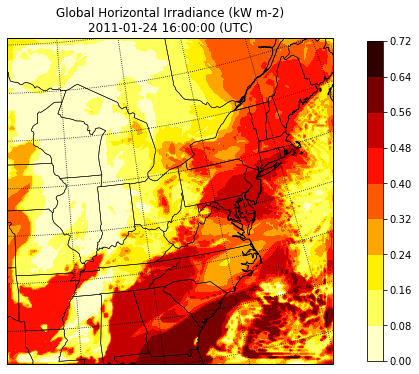

In [12]:
# Get the desired variable(s)
tidx = 16
timestr = f'2011-01-24 {tidx}:00:00'
dni_orig = getvar(ncdata_orig, "SWDDNI", timeidx=tidx)

dni = ncdata.dni.sel(Time=timestr)
ghi = ncdata.ghi.sel(Time=timestr)
ghi = ghi / 1000

# Smooth the variable if it tends to be noisy 
smooth_var = smooth2d(ghi, 3, cenweight=4)

# Get the latitude and longitude points
lats, lons = latlon_coords(dni_orig)

# Get the cartopy mapping object
cart_proj = get_cartopy(dni_orig)

# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Make the contour outlines and filled contours for the smoothed sea level
# pressure.
plt.contour(to_np(lons), to_np(lats), to_np(ghi), 10, colors="none",
            transform=crs.PlateCarree())
plt.contourf(to_np(lons), to_np(lats), to_np(ghi), 10,
             transform=crs.PlateCarree(),
             cmap=get_cmap("hot_r"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Set the map bounds
ax.set_xlim(cartopy_xlim(dni_orig))
ax.set_ylim(cartopy_ylim(dni_orig))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title(f"Global Horizontal Irradiance (kW m-2)\n{timestr} (UTC)")

# fig_path = '/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF Solar and Wind/figures/GHI_plot.png'
# plt.savefig(fig_path, transparent=True, bbox_inches='tight')
plt.show()

In [13]:
dni_orig

<xarray.DataArray 'SWDDNI' (south_north: 191, west_east: 191)>
array([[854.42017 , 862.03424 , 862.0363  , ..., 423.11484 , 354.10306 ,
        263.52124 ],
       [455.58893 , 546.83514 , 776.9582  , ..., 339.20496 , 323.87027 ,
        221.56018 ],
       [259.57764 , 285.21652 , 383.52808 , ...,  88.31887 , 133.60558 ,
        134.91483 ],
       ...,
       [741.1717  , 755.441   , 757.21625 , ..., 134.26918 ,  90.96423 ,
         92.40466 ],
       [752.773   , 767.551   , 764.35345 , ...,  77.20183 ,  71.76728 ,
         71.56576 ],
       [758.75116 , 764.847   , 755.60626 , ..., 105.87521 ,  74.98986 ,
         64.149155]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -95.43335 -95.308044 ... -64.11832
    XLAT     (south_north, west_east) float32 30.952759 30.950832 ... 47.507103
    XTIME    float32 1740.0
    Time     datetime64[ns] 2011-01-24T17:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  Shortwave surface downward direct normal irradiance
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.0, moad_cen_lat=40.259845733...